# Introduction
The goal of the analysis is to predict default of the customer in the next month based on the provided data
## Provided data
##### ID: ID of each client  
##### LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
##### SEX: Gender (1=male, 2=female)
##### EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
##### MARRIAGE: Marital status (1=married, 2=single, 3=others)
##### AGE: Age in years
##### PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
##### PAY_2: Repayment status in August, 2005 (scale same as above)
##### PAY_3: Repayment status in July, 2005 (scale same as above)
##### PAY_4: Repayment status in June, 2005 (scale same as above)
##### PAY_5: Repayment status in May, 2005 (scale same as above)
##### PAY_6: Repayment status in April, 2005 (scale same as above)
##### BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
##### BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
##### BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
##### BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
##### BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
##### BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
##### PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
##### PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
##### PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
##### PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
##### PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
##### PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
##### default.payment.next.month: Default payment (1=yes, 0=no)

## Data analysis
Let's download our data and check the key feautures of the data

In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import seaborn as sns
import numpy as np
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import numpy as np

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_72e67ad04c58438082e9e1224b9e6dc2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='Fqc8Ca3NUBZIBN3jZ0CHkpcbqkE7DvxQETfzBJgqPa8H',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_72e67ad04c58438082e9e1224b9e6dc2.get_object(Bucket='capstoneprojectibm-donotdelete-pr-5sdbnsktcwo384',Key='UCI_Credit_Card.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data = pd.read_csv(body)
df_data.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null float64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null float64
BILL_AMT2                     30000 non-null float64
BILL_AMT3                     30000 non-null float64
BILL_AMT4                     30000 non-null float64
BILL_AMT5                     30000 non-null float64
BILL_AMT6   

Before we start analzing data/features and data cleaning/sorting. I would run some basic classification algorithms to calculate baseline accuracy of the model

Let's define X,Y:

In [161]:
X = df_data.drop(['default.payment.next.month'], axis = 1)
y = df_data['default.payment.next.month'].values


In [162]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=2)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (24000, 24) (24000,)
Test set: (6000, 24) (6000,)


## KNN model

In [6]:
k = 7
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh
yhat_KNN = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat_KNN))

Train set Accuracy:  0.8025416666666667
Test set Accuracy:  0.7621666666666667


In [7]:
Ks = 10
mean_acc = np.zeros((Ks-1))
mean_jaccard = np.zeros((Ks-1))
mean_f1 = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_KNN=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_KNN)
    mean_jaccard[n-1] = jaccard_similarity_score(y_test, yhat_KNN)
    mean_f1[n-1] = f1_score(y_test, yhat_KNN, average='weighted')

print(mean_acc)
print(mean_jaccard)
print(mean_f1)

[0.69116667 0.76033333 0.72566667 0.7655     0.74883333 0.769
 0.76216667 0.7735     0.7645    ]
[0.69116667 0.76033333 0.72566667 0.7655     0.74883333 0.769
 0.76216667 0.7735     0.7645    ]
[0.68986412 0.70423827 0.70319008 0.71012897 0.71319821 0.70856864
 0.71898267 0.71186873 0.71507615]


## Decision Tree

In [163]:
from sklearn.tree import DecisionTreeClassifier
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
drugTree.fit(X_train,y_train)
yhat_Tree=drugTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_Tree))
print("Jaccard score Tree", jaccard_similarity_score(y_test, yhat_Tree))
print("F1 score Tree", f1_score(y_test, yhat_Tree, average='weighted') )
print("ROC_AUC score", roc_auc_score(y_test, yhat_Tree))

DecisionTrees's Accuracy:  0.8146666666666667
Jaccard score Tree 0.8146666666666667
F1 score Tree 0.7960605529959712
ROC_AUC score 0.659448197791346


## Logistic regression

In [12]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat_LR = LR.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_LR))
print("Jaccard score LR", jaccard_similarity_score(y_test, yhat_LR))
print("F1 score LR", f1_score(y_test, yhat_LR, average='weighted'))

DecisionTrees's Accuracy:  0.7776666666666666
Jaccard score LR 0.7776666666666666
F1 score LR 0.6805726749801223


## Support Vector Machine

In [13]:

import scipy.optimize as opt
from sklearn import svm

SVM_approach = svm.SVC(kernel='rbf')
SVM_approach.fit(X_train, y_train) 
yhat_SVM = SVM_approach.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_SVM))
print("Jaccard score SVM", jaccard_similarity_score(y_test, yhat_SVM))
print("F1 score SVM", f1_score(y_test, yhat_SVM, average='weighted') )

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


DecisionTrees's Accuracy:  0.7775
Jaccard score SVM 0.7775
F1 score SVM 0.6801758087201125


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Data analysis
In the previous section we have estimated "baseline" accuracy/f1/jaccard score. In this section we will perform data cleaning + analyze feature (maybe we will add some features)

In [14]:
X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,2,120000.0,2,2,2,26,-1,2,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,3,90000.0,2,2,2,34,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,4,50000.0,2,2,1,37,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


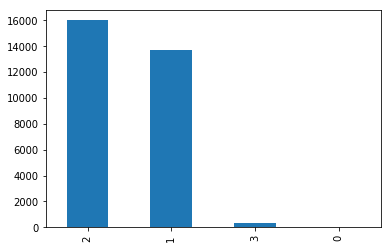

In [25]:
X.MARRIAGE.value_counts().plot(kind = 'bar')

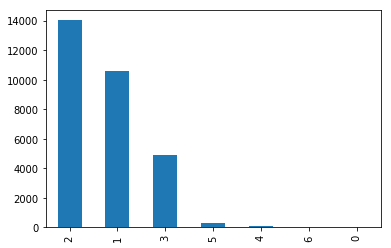

In [26]:
X.EDUCATION.value_counts().plot(kind = 'bar')

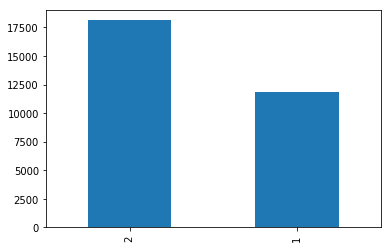

In [27]:
X.SEX.value_counts().plot(kind = 'bar')

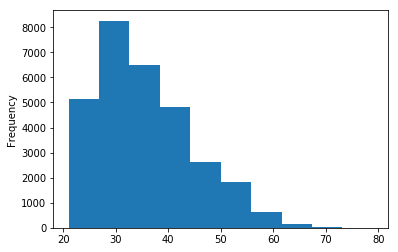

In [30]:
X.AGE.plot(kind = 'hist')

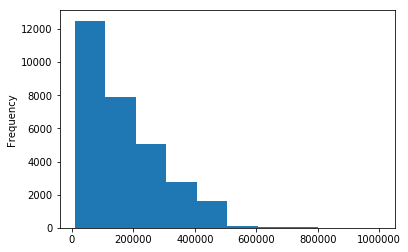

In [32]:
X.LIMIT_BAL.plot(kind = 'hist')

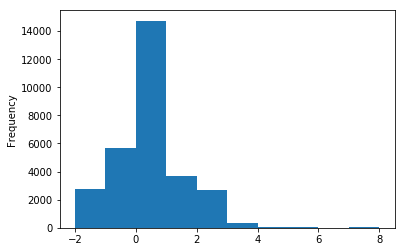

In [6]:
X.PAY_0.plot(kind = 'hist')

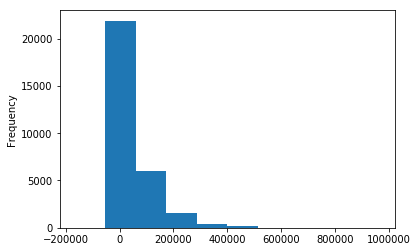

In [7]:
X.BILL_AMT1.plot(kind = 'hist')

We have identified some inconcistencies in the data: Negative PAY_0 - which is not possible (it should be zero or >1); Negative Bill amounts (which doesn't make sense because this is credit cards); for Education we have 6groups (groups 5,4,6,0 are not identified); for MARRIAGE status we have categoty 3,0). 
Let's clean data a bit

In [10]:
df_data1 = df_data
fil = (df_data1.EDUCATION == 5) | (df_data1.EDUCATION == 6) | (df_data1.EDUCATION == 0)
df_data1.loc[fil, 'EDUCATION'] = 4
df_data1.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [11]:
fil = (df_data1.MARRIAGE == 0)
df_data1.loc[fil, 'MARRIAGE'] = 3
df_data1.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [12]:
fil = (df_data1.PAY_0 == -2) | (df_data1.PAY_0 == -1) | (df_data1.PAY_0 == 0)
df_data1.loc[fil, 'PAY_0'] = 0
fil = (df_data1.PAY_2 == -2) | (df_data1.PAY_2 == -1) | (df_data1.PAY_2 == 0)
df_data1.loc[fil, 'PAY_2'] = 0
fil = (df_data1.PAY_3 == -2) | (df_data1.PAY_3 == -1) | (df_data1.PAY_3 == 0)
df_data1.loc[fil, 'PAY_3'] = 0
fil = (df_data1.PAY_4 == -2) | (df_data1.PAY_4 == -1) | (df_data1.PAY_4 == 0)
df_data1.loc[fil, 'PAY_4'] = 0
fil = (df_data1.PAY_5 == -2) | (df_data1.PAY_5 == -1) | (df_data1.PAY_5 == 0)
df_data1.loc[fil, 'PAY_5'] = 0
fil = (df_data1.PAY_6 == -2) | (df_data1.PAY_6 == -1) | (df_data1.PAY_6 == 0)
df_data1.loc[fil, 'PAY_6'] = 0
df_data1.PAY_0.value_counts()

0    23182
1     3688
2     2667
3      322
4       76
5       26
8       19
6       11
7        9
Name: PAY_0, dtype: int64

In [13]:
df_data1['BILL_AMT1' < 0].hear(10)

TypeError: '<' not supported between instances of 'str' and 'int'

In [17]:
df_data1[ (df_data1.BILL_AMT1 < 0) ].head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
26,27,60000.0,1,1,2,27,1,0,0,0,...,-57.0,127.0,-189.0,0.0,1000.0,0.0,500.0,0.0,1000.0,1
68,69,130000.0,2,3,2,29,1,0,0,0,...,10311.0,10161.0,7319.0,0.0,0.0,20161.0,0.0,7319.0,13899.0,0
92,93,100000.0,2,1,2,27,0,0,0,0,...,0.0,0.0,0.0,7555.0,0.0,0.0,0.0,0.0,0.0,0
101,102,380000.0,2,1,2,30,0,0,0,0,...,32891.0,33564.0,34056.0,223.0,33178.0,1171.0,1197.0,1250.0,5000.0,0
109,110,360000.0,1,2,1,35,1,0,0,0,...,-103.0,-103.0,-103.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
df_data1.shape

(30000, 25)

In [30]:
df_data2 = df_data1.drop(df_data1[(df_data1.BILL_AMT1 <= 0)].index , axis = 0)
df_data2.shape

(27402, 25)

Ok, now we made some data cleaning and removed data with negative BILL_AMT1 (negative bill amount for credit card doesn't make sense)

In [26]:
df_data1[(df_data1.BILL_AMT1 == 0)]['default.payment.next.month'].value_counts()

0    1474
1     534
Name: default.payment.next.month, dtype: int64

Not sure whether i understand how to interpert these results. There are almost 2000 customers with outstanding balance 0 in sep, however, 534 are defaulted on the payment next month, which is not possible becasue there is not payment next month. I guess that Bill_AMT1 = 0 is a separate case, thus, for the purposes of this analysis i will exclude all elements with Bill_AMT1 = 0

In [31]:
df_data2.shape

(27402, 25)

In [32]:
df_data2.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,0,0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,0,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,0,0,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
7,8,100000.0,2,2,2,23,0,0,0,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
8,9,140000.0,2,3,1,28,0,0,2,0,...,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
10,11,200000.0,2,3,2,34,0,0,2,0,...,2513.0,1828.0,3731.0,2306.0,12.0,50.0,300.0,3738.0,66.0,0


As we can see Bill amount and payment amounts have huge deviation (customer by customer), to normalize it, i will divide Bill, Paymentsby limit balance of each customer

In [38]:
df_data2['BILL_AMT1_N'] = (df_data2['BILL_AMT1']) / df_data2['LIMIT_BAL']
df_data2['BILL_AMT2_N'] = (df_data2['BILL_AMT2']) / df_data2['LIMIT_BAL']
df_data2['BILL_AMT3_N'] = (df_data2['BILL_AMT3']) / df_data2['LIMIT_BAL']
df_data2['BILL_AMT4_N'] = (df_data2['BILL_AMT4']) / df_data2['LIMIT_BAL']
df_data2['BILL_AMT5_N'] = (df_data2['BILL_AMT5']) / df_data2['LIMIT_BAL']
df_data2['BILL_AMT6_N'] = (df_data2['BILL_AMT6']) / df_data2['LIMIT_BAL']


Now I want to estimate how Client was paying their bills (what amount was paid compared to total bill).It will be an indicator of clietn discipline

In [109]:
df_data2['PAY_AMT1_N'] = (df_data2['PAY_AMT1']) / df_data2['BILL_AMT2']
df_data2['PAY_AMT2_N'] = (df_data2['PAY_AMT2']) / df_data2['BILL_AMT3']
df_data2['PAY_AMT3_N'] = (df_data2['PAY_AMT3']) / df_data2['BILL_AMT4']
df_data2['PAY_AMT4_N'] = (df_data2['PAY_AMT4']) / df_data2['BILL_AMT5']
df_data2['PAY_AMT5_N'] = (df_data2['PAY_AMT5']) / df_data2['BILL_AMT6']

In [111]:
fil = (df_data2.PAY_AMT1_N < 0) | (df_data2.PAY_AMT1_N > 2) 
df_data2.loc[fil, 'PAY_AMT1_N'] = 0
fil = (df_data2.PAY_AMT2_N < 0) | (df_data2.PAY_AMT2_N > 2) 
df_data2.loc[fil, 'PAY_AMT2_N'] = 0
fil = (df_data2.PAY_AMT3_N < 0) | (df_data2.PAY_AMT3_N > 2) 
df_data2.loc[fil, 'PAY_AMT3_N'] = 0
fil = (df_data2.PAY_AMT4_N < 0) | (df_data2.PAY_AMT4_N > 2) 
df_data2.loc[fil, 'PAY_AMT4_N'] = 0
fil = (df_data2.PAY_AMT5_N < 0) | (df_data2.PAY_AMT5_N > 2) 
df_data2.loc[fil, 'PAY_AMT5_N'] = 0

In [112]:

df_data2['PAY_AMT_Average_N'] = df_data2[['PAY_AMT1_N','PAY_AMT2_N','PAY_AMT3_N','PAY_AMT4_N','PAY_AMT5_N']].mean(axis=1)
df_data2.head(10)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5_N,BILL_AMT6_N,PAY_AMT1_N,PAY_AMT2_N,PAY_AMT3_N,PAY_AMT4_N,PAY_AMT5_N,PAY_AMT_Average_N,AgeBin,SEX_and_Marriage
0,1,20000.0,2,2,1,24,2,2,0,0,...,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,0.500000,1,4
1,2,120000.0,2,2,2,26,0,2,0,0,...,0.028792,0.027175,0.000000,0.372856,0.305623,0.289436,0.000000,0.193583,2,5
2,3,90000.0,2,2,2,34,0,0,0,0,...,0.166089,0.172767,0.108220,0.110628,0.069779,0.066899,0.064313,0.083968,3,5
3,4,50000.0,2,2,1,37,0,0,0,0,...,0.579180,0.590940,0.041465,0.040961,0.042382,0.037985,0.036180,0.039794,4,4
4,5,50000.0,1,2,1,57,0,0,0,0,...,0.382920,0.382620,0.352734,1.023608,0.477555,0.470072,0.036015,0.471997,7,1
5,6,50000.0,1,1,2,37,0,0,0,0,...,0.392380,0.400480,0.043807,0.031506,0.033876,0.050971,0.049940,0.042020,4,2
6,7,500000.0,1,1,2,29,0,0,0,0,...,0.966006,0.947888,0.133488,0.089886,0.070026,0.041902,0.029012,0.072863,2,2
7,8,100000.0,2,2,2,23,0,0,0,0,...,-0.001590,0.005670,1.000000,1.000000,0.000000,0.000000,0.000000,0.400000,1,5
8,9,140000.0,2,3,1,28,0,0,2,0,...,0.084236,0.026564,0.236166,0.000000,0.035378,0.084796,0.268889,0.125046,2,4
10,11,200000.0,2,3,2,34,0,0,2,0,...,0.009140,0.018655,0.235619,0.002168,0.019897,0.164114,1.001876,0.284735,3,5


Let's split categories by age

In [45]:
def correlation_columns(Col1, Col2):
    res = df_data2.groupby([Col1, Col2]).size().unstack()
    res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

In [48]:
correlation_columns('EDUCATION', 'default.payment.next.month')

default.payment.next.month,0,1,perc
EDUCATION,,,
1,7600,1707,0.183410
2,9994,3115,0.237623
3,3424,1139,0.249616
4,391,32,0.075650


In [49]:
correlation_columns('SEX', 'default.payment.next.month')

default.payment.next.month,0,1,perc
SEX,,,
1,8398,2636,0.238898
2,13011,3357,0.205095


In [50]:
correlation_columns('MARRIAGE', 'default.payment.next.month')

default.payment.next.month,0,1,perc
MARRIAGE,,,
1,9527,2879,0.232065
2,11612,3030,0.206939
3,270,84,0.237288


In [54]:
df_data2['SEX_and_Marriage'] = 0
df_data2.loc[((df_data2.SEX == 1) & (df_data2.MARRIAGE == 1)) , 'SEX_and_Marriage'] = 1 #married man
df_data2.loc[((df_data2.SEX == 1) & (df_data2.MARRIAGE == 2)) , 'SEX_and_Marriage'] = 2 #single man
df_data2.loc[((df_data2.SEX == 1) & (df_data2.MARRIAGE == 3)) , 'SEX_and_Marriage'] = 3 #divorced man
df_data2.loc[((df_data2.SEX == 2) & (df_data2.MARRIAGE == 1)) , 'SEX_and_Marriage'] = 4 #married woman
df_data2.loc[((df_data2.SEX == 2) & (df_data2.MARRIAGE == 2)) , 'SEX_and_Marriage'] = 5 #single woman
df_data2.loc[((df_data2.SEX == 2) & (df_data2.MARRIAGE == 3)) , 'SEX_and_Marriage'] = 6 #divorced woman
correlation_columns('SEX_and_Marriage', 'default.payment.next.month')

default.payment.next.month,0,1,perc
SEX_and_Marriage,,,
1,3564,1218,0.254705
2,4733,1380,0.225748
3,101,38,0.273381
4,5963,1661,0.217865
5,6879,1650,0.193458
6,169,46,0.213953


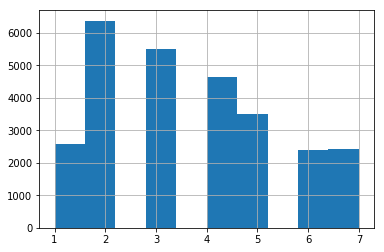

In [56]:
df_data2['AgeBin'] = 0 #creates a column of 0
df_data2.loc[((df_data2['AGE'] > 20) & (df_data2['AGE'] < 25)) , 'AgeBin'] = 1
df_data2.loc[((df_data2['AGE'] >= 25) & (df_data2['AGE'] < 30)) , 'AgeBin'] = 2
df_data2.loc[((df_data2['AGE'] >= 30) & (df_data2['AGE'] < 35)) , 'AgeBin'] = 3
df_data2.loc[((df_data2['AGE'] >= 35) & (df_data2['AGE'] < 40)) , 'AgeBin'] = 4
df_data2.loc[((df_data2['AGE'] >= 40) & (df_data2['AGE'] < 45)) , 'AgeBin'] = 5
df_data2.loc[((df_data2['AGE'] >= 45) & (df_data2['AGE'] < 50)) , 'AgeBin'] = 6
df_data2.loc[ (df_data2['AGE'] >= 50) , 'AgeBin'] = 7

df_data2.AgeBin.hist()

In [57]:
correlation_columns('AgeBin', 'default.payment.next.month')

default.payment.next.month,0,1,perc
AgeBin,,,
1,1861,708,0.275594
2,5026,1343,0.210865
3,4445,1042,0.189903
4,3679,971,0.208817
5,2730,782,0.222665
6,1828,564,0.235786
7,1840,583,0.240611


In [113]:
features = ['LIMIT_BAL', 'EDUCATION', 'MARRIAGE', 
            'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
            #'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
            'BILL_AMT1_N', 'BILL_AMT2_N','BILL_AMT3_N', 'BILL_AMT4_N', 'BILL_AMT5_N', 'BILL_AMT6_N', 
            #'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
            'PAY_AMT1_N','PAY_AMT2_N', 'PAY_AMT3_N', 'PAY_AMT4_N', 'PAY_AMT5_N',
            'AgeBin', 'PAY_AMT_Average_N','SEX_and_Marriage'
           ]

In [114]:
df_data2 = df_data2.replace([np.inf, -np.inf], np.nan)

In [115]:
df_data2[['PAY_AMT1_N','PAY_AMT2_N','PAY_AMT3_N','PAY_AMT4_N','PAY_AMT5_N', 'PAY_AMT_Average_N']]= df_data2[['PAY_AMT1_N','PAY_AMT2_N','PAY_AMT3_N','PAY_AMT4_N','PAY_AMT5_N', 'PAY_AMT_Average_N']].fillna(0)

In [116]:
df_data2.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5_N,BILL_AMT6_N,PAY_AMT1_N,PAY_AMT2_N,PAY_AMT3_N,PAY_AMT4_N,PAY_AMT5_N,PAY_AMT_Average_N,AgeBin,SEX_and_Marriage
count,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,...,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000,27402.000000
mean,15009.381833,163473.822349,1.597329,1.857748,1.560178,35.398475,0.328954,0.350266,0.325633,0.277498,...,0.361068,0.345278,0.297932,0.295740,0.273451,0.262914,0.270630,0.311570,3.621670,3.352164
std,8638.304295,129870.675448,0.490445,0.740067,0.521753,9.220631,0.776437,0.832362,0.814976,0.786642,...,0.351579,0.347203,0.405909,0.409239,0.402226,0.400307,0.405214,0.362213,1.761777,1.546307
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-0.876743,-1.509530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,7553.250000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,0.023251,0.016878,0.039330,0.038118,0.034048,0.031995,0.033668,0.043753,2.000000,2.000000
50%,15027.500000,130000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,0.280295,0.249260,0.065986,0.063933,0.050201,0.042638,0.044165,0.088599,3.000000,4.000000
75%,22442.750000,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,0.636133,0.610030,0.446285,0.422284,0.298644,0.251982,0.310813,0.580187,5.000000,5.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,4.935500,3.885550,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,7.000000,6.000000


In [117]:
y1 = df_data2['default.payment.next.month'].copy()
X1 = df_data2[features].copy()
X1.head(10)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1_N,...,BILL_AMT5_N,BILL_AMT6_N,PAY_AMT1_N,PAY_AMT2_N,PAY_AMT3_N,PAY_AMT4_N,PAY_AMT5_N,AgeBin,PAY_AMT_Average_N,SEX_and_Marriage
0,20000.0,2,1,2,2,0,0,0,0,0.195650,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1,0.500000,4
1,120000.0,2,2,0,2,0,0,0,2,0.022350,...,0.028792,0.027175,0.000000,0.372856,0.305623,0.289436,0.000000,2,0.193583,5
2,90000.0,2,2,0,0,0,0,0,0,0.324878,...,0.166089,0.172767,0.108220,0.110628,0.069779,0.066899,0.064313,3,0.083968,5
3,50000.0,2,1,0,0,0,0,0,0,0.939800,...,0.579180,0.590940,0.041465,0.040961,0.042382,0.037985,0.036180,4,0.039794,4
4,50000.0,2,1,0,0,0,0,0,0,0.172340,...,0.382920,0.382620,0.352734,1.023608,0.477555,0.470072,0.036015,7,0.471997,1
5,50000.0,1,2,0,0,0,0,0,0,1.288000,...,0.392380,0.400480,0.043807,0.031506,0.033876,0.050971,0.049940,4,0.042020,2
6,500000.0,1,2,0,0,0,0,0,0,0.735930,...,0.966006,0.947888,0.133488,0.089886,0.070026,0.041902,0.029012,2,0.072863,2
7,100000.0,2,2,0,0,0,0,0,0,0.118760,...,-0.001590,0.005670,1.000000,1.000000,0.000000,0.000000,0.000000,1,0.400000,5
8,140000.0,3,1,0,0,2,0,0,0,0.080607,...,0.084236,0.026564,0.236166,0.000000,0.035378,0.084796,0.268889,2,0.125046,4
10,200000.0,3,2,0,0,2,0,0,0,0.055365,...,0.009140,0.018655,0.235619,0.002168,0.019897,0.164114,1.001876,3,0.284735,5


In [118]:
X_train, X_test, y_train, y_test = train_test_split( X1, y1, test_size=0.2, random_state=5)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (21921, 23) (21921,)
Test set: (5481, 23) (5481,)


## Model
After we made some cleaning and add some additional features. Let's start working on the model

In [119]:
from sklearn.tree import DecisionTreeClassifier
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
drugTree.fit(X_train,y_train)
yhat_Tree=drugTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_Tree))
print("Jaccard score Tree", jaccard_similarity_score(y_test, yhat_Tree))
print("F1 score Tree", f1_score(y_test, yhat_Tree, average='weighted') )

DecisionTrees's Accuracy:  0.8139025725232621
Jaccard score Tree 0.8139025725232621
F1 score Tree 0.797793273638993


In [121]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': np.arange(3, 10),
             'criterion' : ['gini','entropy'],
             'max_leaf_nodes': [5,10,20,100],
             'min_samples_split': [2, 5, 10, 20]}

drugTree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring= 'accuracy')
drugTree.fit(X_train, y_train)
print(drugTree.best_estimator_)
print(np.abs(drugTree.best_score_))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.826239678846768


In [122]:
drugTree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=20,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
drugTree.fit(X_train,y_train)
yhat_Tree=drugTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhat_Tree))
print("Jaccard score Tree", jaccard_similarity_score(y_test, yhat_Tree))
print("F1 score Tree", f1_score(y_test, yhat_Tree, average='weighted') )
print("ROC_AUC score", f1_score(y_test, yhat_Tree, average='weighted') )

DecisionTrees's Accuracy:  0.8244845831052727
Jaccard score Tree 0.8244845831052727
F1 score Tree 0.8090168556314109


By optimizing model we achieved 82.4% accuracy. Let's do further analysis and analyze how important are our features for this model.

In [124]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feat':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result

get_feature_importance(drugTree, features)

,feat,score
3,PAY_0,0.858341
5,PAY_3,0.040984
0,LIMIT_BAL,0.021413
9,BILL_AMT1_N,0.019641
21,PAY_AMT_Average_N,0.017276
4,PAY_2,0.016523
8,PAY_6,0.010646
7,PAY_5,0.007080
18,PAY_AMT4_N,0.005264
13,BILL_AMT5_N,0.002832


In [125]:
correlation_columns('PAY_0', 'default.payment.next.month')

default.payment.next.month,0,1,perc
PAY_0,,,
0,19250,3023,0.135725
1,1206,793,0.396698
2,823,1844,0.691414
3,78,244,0.757764
4,24,52,0.684211
5,13,13,0.500000
6,5,6,0.545455
7,2,7,0.777778
8,8,11,0.578947


As we can see, even after our transofrmations, the most important feature is PAY_0. Let's check TP, TF, FN in our model.

In [126]:

TP = np.sum(np.logical_and(yhat_Tree == 1, y_test == 1))
TN = np.sum(np.logical_and(yhat_Tree == 0, y_test == 0))
FP = np.sum(np.logical_and(yhat_Tree == 1, y_test == 0))
FN = np.sum(np.logical_and(yhat_Tree == 0, y_test == 1))
 
print('TP: {}, FP: {}, TN: {}, FN: {}'.format(TP,FP,TN,FN))

TP: 493, FP: 262, TN: 4026, FN: 700


In [128]:
import numpy as np
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, yhat_Tree)

0.6760715883074151

# LightGBM model
Let's try another model which maybe be usefull for this analysis
### Model parameters

In [143]:
!pip install lightgbm
import lightgbm as lgb

     |████████████████████████████████| 1.8MB 7.8MB/s eta 0:00:01


In [144]:

params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':50, # because training data is sightly unbalanced 
         }

In [151]:
categorical_features = ['EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'SEX_and_Marriage', 'AgeBin']

In [148]:
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

In [152]:
dtrain = lgb.Dataset(X_train[features].values, 
                     label=y_train.values,
                     feature_name=features,
                     categorical_feature=categorical_features)

dvalid = lgb.Dataset(X_test[features].values,
                     label=y_test.values,
                     feature_name=features,
                     categorical_feature=categorical_features)

In [153]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

del dvalid
gc.collect()

/opt/conda/envs/Python36/lib/python3.6/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080863 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 50 rounds


/opt/conda/envs/Python36/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/conda/envs/Python36/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[50]	train's auc: 0.790812	valid's auc: 0.782009
[100]	train's auc: 0.801275	valid's auc: 0.787656
[150]	train's auc: 0.807074	valid's auc: 0.788028
Early stopping, best iteration is:
[140]	train's auc: 0.80593	valid's auc: 0.788407


141

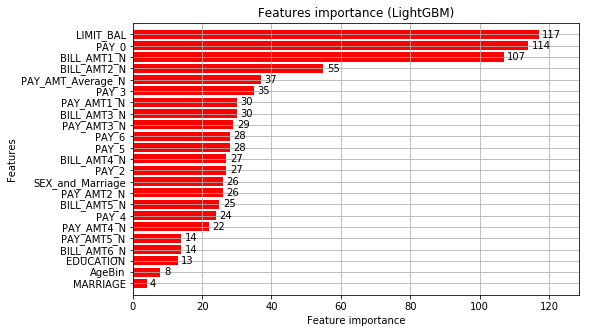

In [154]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

As you can see, by applying LightGBM model we were able to increase ROC_AUC score from 0.66 to 0.78